# Likelihood-Free Inference - Model Training

Ali Al Kadhim and Harrison B. Prosper<br>
Department of Physics, Florida State University<br>
Date: 22 April 2022

## Introduction

The jargon likelihood-free inference (LFI) is somewhat unfortunate. For any Monte Carlo-based simulation there is clearly an underlying probability model from which we are implicitly sampling. 
The likelihood, that is, the probability model after data have been entered into it exists in the same sense that $\pi$ exists. While it is impossible to write down all of the digits of $\pi$, these digits exist nevertheless! Likewise the likelihood, though typically intractable, exists also.

A better name, perhaps, for this inference approach is __Simulation-Based Inference (SBI)__, which better expresses the idea that one makes inferences directly from accurate simulations of the data generation mechanism without the need for explicit knowledge of the likelihood. The key idea is that the ensemble of simulations constitute a point-cloud approximation to the probability model. 

LFI focuses directly on the statistical quantities that are of direct interest such as p-values and confidence intervals in a frequentist setting or summaries of posterior densities such as the first few moments or its quantiles. The key insight (see, for example, Ann Lee et al. [1]) is that it is generally easier to compute integrals of densities than the densities themselves.

In this project, we use a classic problem in statistics to investigate different ways of accounting for nuisance parameters inspired by the paper cited above.

## The Poisson Problem: A Single Count

Computing confidence intervals with exact coverage for the parameter $\theta$ of the Poisson distribution

\begin{align}
\textrm{Poisson}(n, \theta) & = \frac{e^{-\theta} \theta^n}{n!}, 
\end{align}

is a classic problem in statistics. Exact coverage means that the following is true

\begin{align}
    P\{ \theta \in [ \, \underline{\theta}(n), \, \overline{\theta}(n) \, ] \, \} \geq 1 - \alpha, \forall \, \theta
\end{align}

where $P$ is the __coverage probability__, $1 - \alpha$ the confidence level (CL), and $\alpha$ is the size of the associated hypothesis test. The quantity $[ \, \underline{\theta}(n), \, \overline{\theta}(n) \, ]$ is a *random* interval. The statement above means that in an infinite ensemble of experiments, each of which may be associated with a different *fixed* value of the parameter $\theta$, the fraction of intervals that include $\theta$, that is, that *cover* $\theta$, is bounded below by the confidence level (CL). Moreover, this holds true irrespective of the distribution of $\theta$ values over the ensemble of experiments. 

Jerzy Neyman[2], the inventor of confidence intervals, required coverage probabilities to be bounded from below by the confidence level whatever the true values of *all* the parameters of the problem. In general, however, it is difficult to create random intervals with this property for multi-parameter problems. But for 1-parameter problems confidence intervals with exact coverage can be constructed. In his 1937 paper[2], Neyman provided a simple algorithm to compute such intervals, which in this tutorial apply to the Poisson distribution.

### Algorithm
Define the *right* and *left* cumulative distribution functions of the Poisson distribution,
 \begin{align}
      D_R(D, \theta) & = \sum_{k=D}^\infty \textrm{Poisson}(k, \theta) = P(D, \theta),\\
      \textrm{and   } D_L(D, \theta) & = \sum_{k=0}^D \textrm{Poisson}(k, \theta) = 1 - P(D+1, \theta).
 \end{align}
The function $P(s, \theta)$ is the *normalized* lower incomplete gamma function[3].
We use the function $D_L$ to compute __upper limits__ and $D_R$ to compute __lower limits__ by solving the equations
\begin{align}
    D_R(D, \underline{\theta}) & = \alpha_R,\\
    D_L(D, \overline{\theta}) & =  \alpha_L,
\end{align}

where $\text{CL} + \alpha_R + \alpha_L = 1$. Clearly there are infinitely many ensembles of exact condidence intervals that can be computed for any 1-parameter distribution. It is, therefore, a matter of convention which one is reported. Very often, the following convention is used: one sets $\alpha_R = \alpha_L = (1 - \text{CL})/2$ to arrive at __central intervals__.


In this notebook, we use the method of Ref.[1] to fit a simple deep neural network model to data comprising the triplets $(Z_i, \theta_i, D_i)$ (see notebook __LFI_generate_data.ipynb__) and approximate $E(Z | \theta, D)$, that is, $D_L(D, \theta)$ using a simple deep neural network.

This tutorial is about the 1-parameter problem. 


## Research Question
However, the goal of our project is to investigate the following 2-parameter problem

\begin{align}
    p(n, m| \theta, \nu) & = \textrm{Poisson}(n, \theta + \nu)\, \textrm{Poisson}(m, \nu),
\end{align}

which contains one nuisance parameter, namely, $\nu$. Although this is the simplest Poisson problem with a constrained nuisance parameter, surprisingly, none of the standard methods yield upper limits for $\theta$ with exact coverage! One of our goals is to tackle this problem starting with a slight generalization of the method of Ref.[1]. 

We shall build a model that approximates $E(Z | \theta, \nu, n, m)$,
where 

$$Z = I[ \lambda^\prime(n, m) \leq \lambda(N, M) ],$$ 

where the single count $D$ is now replaced by the two counts $N$ and $M$ and $\lambda(n, m)$ is a test statistic. The research question is: can we find a function $\lambda$ modeled with a neural network such that

\begin{align}
    \frac{\partial E(Z | \theta, \nu, n, m)}{\partial \nu} & = 0, \quad\forall \, \theta, n, \text{ and } m 
\end{align}

that is, such that the expectation value of $Z$ is insensitive to, and ideally independent of, the nuisance parameter $\nu$. In other words, can we find a functional form for $\lambda$ whose distribution is independent of $\nu$?


### References
  1. Anne Lee et al., https://arxiv.org/abs/2107.03920
  2. Neyman, Jerzy (1937). "Outline of a Theory of Statistical Estimation Based on the Classical Theory of Probability". Philosophical Transactions of the Royal Society of London. Series A, Mathematical and Physical Sciences. 236 (767): 333–380. doi:10.1098/rsta.1937.0005.
  3. https://en.wikipedia.org/wiki/Incomplete_gamma_function. The normalized function is the unnormalized function divided by $\Gamma(s)$ and can be computed using scipy.special.gammainc($s$, $\theta$).

In [1]:
import os, sys

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

# standard scientific python module
import scipy as sp
import scipy.stats as st

# standard symbolic algebra module
import sympy as sm
sm.init_printing()

#  a function to save results
import joblib as jb

# pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset

#  split data into a training set and a test set
from sklearn.model_selection import train_test_split

# to reload modules
import importlib

%matplotlib inline

In [2]:
# update fonts
FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

### Load data

In [14]:
datafile = 'data.db'
print('loading %s' % datafile)
data = jb.load(datafile)

inputs = ['theta', 'D']

data[:5]

loading data.db


,Z,theta,D
0,0,13.612745,7
1,0,18.209968,3
2,0,5.557285,5
3,0,4.839835,0
4,0,4.588637,6


$
\begin{align}
      D_R(D, \theta) & = \sum_{k=D}^\infty \textrm{Poisson}(k, \theta) = P(D, \theta),\\
      \textrm{and   } D_L(D, \theta) & = \sum_{k=0}^D \textrm{Poisson}(k, \theta) = 1 - P(D+1, \theta).
\end{align}
$

In [4]:
def DR(s, theta):
    return sp.special.gammainc(s, theta)

def DL(s, theta):
    return 1 - sp.special.gammainc(s+1, theta)

### Plot data

Check that data make sense. Compute $D_L$ by histogramming the data and compute $D_L$$ exactly.


Note: __matplotlib__ has two graphics systems: 1) function-based and 2) object-based. The function below illustrates the object-based system.

In [10]:
# Check that histogrammed data agrees with exact calculation of DL.

xmin, xmax = 0, 20
xrange= (xmin, xmax)
xbins = 40
xstep = (xmax - xmin) / xbins
x     = np.arange(xmin+0.5*xstep, xmax + 0.5*xstep, xstep)

def hist_data(data, D, x):
    
    select = data.D == D

    # weighted histogram   (count the number of ones per bin)
    y1, _ = np.histogram(data.theta[select], 
                         bins=xbins, 
                         range=xrange, 
                         weights=data.Z[select]) 

    # unweighted histogram (count number of ones and zeros per bin)
    yt, _ = np.histogram(data.theta[select], 
                         bins=xbins, 
                         range=xrange)

    # approximation of DL(D, x)
    y =  y1 / yt    

    # exact
    p = DL(D, x)
    
    return (y, p)

In [11]:
def plot_data(data, func, Dmin, Dmax, x, 
              gfile='fig_data.png', 
              fgsize=(10, 6)):
    
    # make room for 6 sub-plots
    fig, ax = plt.subplots(nrows=2, 
                           ncols=3, 
                           figsize=fgsize)
    
    # padding
    plt.subplots_adjust(hspace=0.01)
    plt.subplots_adjust(wspace=0.20)
    
    # use flatten() to convert a numpy array of 
    # shape (nrows, ncols) to a 1-d array. 
    ax = ax.flatten()
    
    for j, d in enumerate(range(Dmin, Dmax+1)):
        
        # compute DL 
        y, p = func(data, d, x)
        
        ax[j].set_xlim(xmin, xmax)
        ax[j].set_ylim(0, 1)
        ax[j].set_xlabel(r'$\theta$', fontsize=FONTSIZE)
        ax[j].set_ylabel(r'$E(Z|\theta)$', fontsize=FONTSIZE)
        
        ax[j].plot(x, y, 'b', lw=2, label='approx')
        ax[j].plot(x, p, 'r', lw=2, label='exact')
        
        ax[j].grid(True, which="both", linestyle='-')
        ax[j].text(12, 0.42, r'$D = %d$' % d, fontsize=FONTSIZE) 

        ax[j].legend(loc='upper right')
        
    # hide unused sub-plots
    for k in range(Dmax+1-Dmin, len(ax)):
        ax[k].set_visible(False)
    
    plt.tight_layout()
    plt.savefig(gfile)
    plt.show()

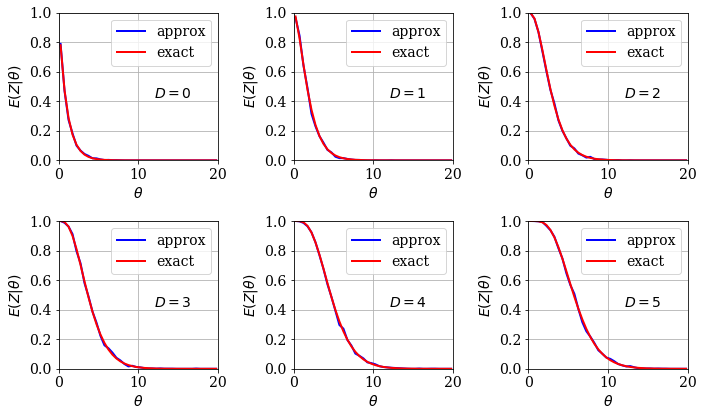

In [12]:
Dmin, Dmax = 0, 5
plot_data(data, hist_data, Dmin, Dmax, x) 

### Train, validation, and test sets
There is some confusion in terminology regarding validation and test samples (or sets). We shall adhere to the defintions given here https://machinelearningmastery.com/difference-test-validation-datasets/):
   
  * __Training Dataset__: The sample of data used to fit the model.
  * __Validation Dataset__: The sample of data used to decide 1) whether the fit is reasonable (e.g., the model has not been overfitted), 2) decide which of several models is the best and 3) tune model hyperparameters.
  * __Test Dataset__: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

The validation set will be some small fraction of the training set and will be used to decide when to stop the training.

In [16]:
# Fraction of the data assigned as test data
fraction = 1/102
# Split data into a part for training and a part for testing
train_data, test_data = train_test_split(data, 
                                         test_size=fraction)

# Split the training data into a part for training (fitting) and
# a part for validating the training.
fraction = 1/101
train_data, valid_data = train_test_split(train_data, 
                                          test_size=fraction)

# reset the indices in the dataframes
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)
test_data  = test_data.reset_index(drop=True)

print('train set size:        %6d' % train_data.shape[0])
print('validation set size:   %6d' % valid_data.shape[0])
print('test set size:         %6d' % test_data.shape[0])

train_data[:5][inputs]

train set size:        500000
validation set size:     5000
test set size:           5000


,theta,D
0,3.461724,4
1,2.526797,5
2,18.899436,4
3,7.142903,1
4,2.728556,7


Split data into targets $t$ and inputs $\mathbf{x}$

In [17]:
def split_t_x(df, inp=inputs):
    # change from pandas dataframe format to a numpy 
    # array of the specified types
    t = np.array(df['Z'])
    x = np.array(df[inp])
    return (t, x)

train_t, train_x = split_t_x(train_data)
valid_t, valid_x = split_t_x(valid_data)
test_t,  test_x  = split_t_x(test_data)

### Return a (random) batch of data from the training set

In [18]:
def get_batch(x, t, batch_size):
    # the numpy function choice(length, number)
    # selects at random "batch_size" integers from 
    # the range [0, length-1] corresponding to the
    # row indices.
    rows    = rnd.choice(len(x), batch_size)
    batch_x = x[rows]
    batch_t = t[rows]
    return (batch_x, batch_t)

### Empirical risk (that is, average loss)

The empirical risk, which is the __objective function__ we shall minimize, is defined as

\begin{align}
R_M(\theta) & = \frac{1}{M}\sum_{m=1}^M L(t_m, f_m),
\end{align}

where 

\begin{align*}
    f_m & \equiv f(\mathbf{x}_m, \theta),\\ \\ \textrm{and} \\
    L(t, f) &= (t - f)^2
\end{align*}

The empirical risk $R_M$ approximates the __risk__

\begin{align}
R[f] & = \int \cdots \int \, p(t, \mathbf{x}) \, L(t, f(\mathbf{x}, \theta)) \, dt \, d\mathbf{x},
\end{align}

which is a __functional__ of the model $f$. The quantity $p(t, \mathbf{x}) \, dt\, d\mathbf{x}$ is the probability distribution from which the sample $\{ (t_m, \mathbf{x}_m), m = 1,\cdots, M \}$ is presumed to have been drawn. 

In [19]:
# Note: there are several average loss functions available 
# in pytorch, but it's useful to know how to create your own.
def average_loss(f, t):
    # f and t must be of the same shape
    return  torch.mean((f - t)**2)

This function is used to validate the model while the it is being fitted.

In [20]:
def validate(model, avloss, inputs, targets):
    # make sure we set evaluation mode so that any training specific
    # operations are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x and t
        x = torch.from_numpy(inputs).float()
        t = torch.from_numpy(targets).float()
        # remember to reshape!
        o = model(x).reshape(t.shape)
    return avloss(o, t)

### Function to execute training loop

In [27]:
def train(model, optimizer, avloss, getbatch,
          train_x, train_t, 
          valid_x, valid_t,
          batch_size, 
          n_iterations, traces, 
          step=50):
    
    # to keep track of average losses
    xx, yy_t, yy_v = traces
    
    n = len(valid_x)
    
    print('Iteration vs average loss')
    print("%10s\t%10s\t%10s" % \
          ('iteration', 'train-set', 'valid-set'))
    
    for ii in range(n_iterations):

        # set mode to training so that training specific 
        # operations such as dropout are enabled.
        model.train()
        
        # get a random sample (a batch) of data (as numpy arrays)
        batch_x, batch_t = getbatch(train_x, train_t, batch_size)
        
        # convert the numpy arrays batch_x and batch_t to tensor 
        # types. The PyTorch tensor type is the magic that permits 
        # automatic differentiation with respect to parameters. 
        # However, since we do not need to take the derivatives
        # with respect to x and t, we disable this feature
        with torch.no_grad(): # no need to compute gradients 
            # wrt. x and t
            x = torch.from_numpy(batch_x).float()
            t = torch.from_numpy(batch_t).float()      

        # compute the output of the model for the batch of data x
        # Note: outputs is 
        #   of shape (-1, 1), but the tensor targets, t, is
        #   of shape (-1,)
        # In order for the tensor operations with outputs and t
        # to work correctly, it is necessary that they have the
        # same shape. We can do this with the reshape method.
        outputs = model(x).reshape(t.shape)
   
        # compute a noisy approximation to the average loss
        empirical_risk = avloss(outputs, t)
        
        # use automatic differentiation to compute a 
        # noisy approximation of the local gradient
        optimizer.zero_grad()       # clear previous gradients
        empirical_risk.backward()   # compute gradients
        
        # finally, advance one step in the direction of steepest 
        # descent, using the noisy local gradient. 
        optimizer.step()            # move one step
        
        if ii % step == 0:
            
            acc_t = validate(model, avloss, train_x[:n], train_t[:n]) 
            acc_v = validate(model, avloss, valid_x[:n], valid_t[:n])

            if len(xx) < 1:
                xx.append(0)
                print("%10d\t%10.6f\t%10.6f" % \
                      (xx[-1], acc_t, acc_v))
            else:
                xx.append(xx[-1] + step)
                print("\r%10d\t%10.6f\t%10.6f" % \
                      (xx[-1], acc_t, acc_v), end='')
                
            yy_t.append(acc_t)
            yy_v.append(acc_v)
    print()      
    return (xx, yy_t, yy_v)

In [28]:
def plot_average_loss(traces):
    
    xx, yy_t, yy_v = traces
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)

    ax.set_title("Average loss")
    
    ax.plot(xx, yy_t, 'b', lw=2, label='Training')
    ax.plot(xx, yy_v, 'r', lw=2, label='Validation')

    ax.set_xlabel('Iterations', fontsize=FONTSIZE)
    ax.set_ylabel('average loss', fontsize=FONTSIZE)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which="both", linestyle='-')
    ax.legend(loc='upper right')

    plt.show()

### Define model $f(\mathbf{x}, \theta)$

In [29]:
%%writefile dnnmodel.py

import torch
import torch.nn as nn

class Model(nn.Module):
    
    def __init__(self, n_inputs=2, n_nodes=20, n_layers=5):

        # call constructor of base (or super, or parent) class
        super(Model, self).__init__()

        self.layers = []
        
        # create input layer
        self.layer0 = nn.Linear(n_inputs, n_nodes)
        self.layers.append(self.layer0)

        # create "hidden" layers
        for l in range(1, n_layers):
            cmd = 'self.layer%d = nn.Linear(%d, %d)' % \
            (l, n_nodes, n_nodes)
            exec(cmd)
            cmd = 'self.layers.append(self.layer%d)' % l
            exec(cmd)
          
        # create output layer
        cmd = 'self.layer%d = nn.Linear(%d, 1)' % (n_layers, n_nodes)
        exec(cmd)
        cmd = 'self.layers.append(self.layer%d)' % n_layers
        exec(cmd)

    # define (required) method to compute output of network
    def forward(self, x):
        y = x
        for layer in self.layers[:-1]:
            y = layer(y)
            y = torch.relu(y)
        y = self.layers[-1](y)
        y = torch.sigmoid(y)
        return y


Overwriting dnnmodel.py


In [30]:
import dnnmodel
importlib.reload(dnnmodel)
model = dnnmodel.Model()
print(model)

Model(
  (layer0): Linear(in_features=2, out_features=20, bias=True)
  (layer1): Linear(in_features=20, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=20, bias=True)
  (layer4): Linear(in_features=20, out_features=20, bias=True)
  (layer5): Linear(in_features=20, out_features=1, bias=True)
)


### Train!

Instantiate an optimizer, then train

In [31]:
learning_rate = 1.e-3
optimizer     = torch.optim.Adam(model.parameters(), 
                                 lr=learning_rate) 

traces = ([], [], [])
traces_step = 10

Iteration vs average loss
 iteration	 train-set	 valid-set
         0	  0.230880	  0.230616
     19990	  0.062982	  0.062350
Iteration vs average loss
 iteration	 train-set	 valid-set
     29990	  0.062901	  0.061849


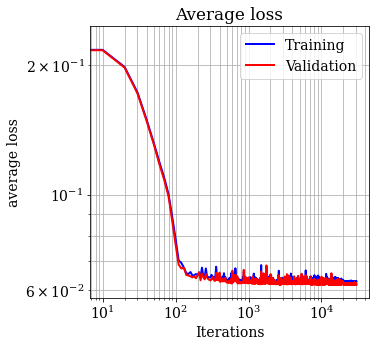

In [32]:
n_batch       = 50
n_iterations  = 20000

traces = train(model, optimizer, average_loss,
               get_batch,
               train_x, train_t, 
               valid_x, valid_t,
               n_batch, 
               n_iterations,
               traces,
               step=traces_step)

n_batch       = 500
n_iterations  = 10000

traces = train(model, optimizer, average_loss,
               get_batch,
               train_x, train_t, 
               valid_x, valid_t,
               n_batch, 
               n_iterations,
               traces,
               step=traces_step)

plot_average_loss(traces)

In [33]:
def usemodel(data, d, x):
    model.eval()
    xx= [[z, d] for z in x]
    X = torch.Tensor(xx)
    y = model(X).detach().numpy()
    p = DL(d, x)
    return (y, p)

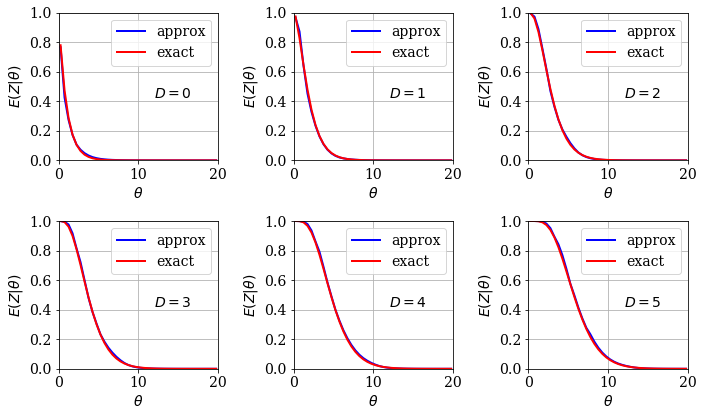

In [34]:
plot_data(data, usemodel, Dmin, Dmax, x, gfile='fig_model_vs_DL.png') 